In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from openTSNE import TSNE
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
datafile_path = "batch.jsonl"
embedding_df = pd.read_json(datafile_path, lines=True)
oil_prices = pd.read_csv("BrentOilPrices.csv")

In [3]:
embedding_df.head()

,id,time,text,embedding
0,batch_req_4JoBhjZiQdW1ureIk55uT60s,2010-01-19T20:07:41+03:00,"Политики рассуждают, потянет ли ""чужак"" А.Хлоп...","[-0.022927681000000002, -0.04193881, -0.020334..."
1,batch_req_PXPaa0KZQLoobcV99qs9KUpv,2010-01-19T19:56:17+03:00,Европейские фондовые индексы закрылись ростом,"[-0.012358208, 0.021774478, 0.0032501156000000..."
2,batch_req_7NtTPb7kG4KJYz01exHj49Al,2010-01-19T19:48:53+03:00,Рынки Европы: инвесторы распродают бонды,"[0.015422983000000001, -0.009314381, -0.004979..."
3,batch_req_luuNEuV6Hd8NIWvoy955pGFP,2010-01-19T18:30:35+03:00,Часть Барнаула осталась без электричества при ...,"[-0.03373116, 0.033114664, -0.0634551, -0.0305..."
4,batch_req_pBkxpDd6yiRqSP9onDN8LWsb,2010-01-19T15:04:00+03:00,МИД: Застрявших в Египте российских туристов п...,"[-0.041608624000000004, 0.023533741, 0.0201573..."


In [4]:
oil_prices.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [5]:
embedding_df["time"] = pd.to_datetime(embedding_df["time"], utc=True)
embedding_df["date"] = embedding_df["time"].dt.strftime("%Y-%m-%d")
embedding_df.drop(["id", "text", "time"], inplace=True, axis=1)

In [6]:
oil_prices["date"] = pd.to_datetime(oil_prices["Date"])
oil_prices.drop(["Date"], inplace=True,  axis=1)

In [7]:
embedding_df.head()

,embedding,date
0,"[-0.022927681000000002, -0.04193881, -0.020334...",2010-01-19
1,"[-0.012358208, 0.021774478, 0.0032501156000000...",2010-01-19
2,"[0.015422983000000001, -0.009314381, -0.004979...",2010-01-19
3,"[-0.03373116, 0.033114664, -0.0634551, -0.0305...",2010-01-19
4,"[-0.041608624000000004, 0.023533741, 0.0201573...",2010-01-19


In [8]:
oil_prices.head()

,Price,date
0,18.63,1987-05-20
1,18.45,1987-05-21
2,18.55,1987-05-22
3,18.60,1987-05-25
4,18.63,1987-05-26


In [9]:
def mean_of_lists(lists):
    return np.mean(lists, axis=0)


agg_embeddings = (
    embedding_df.groupby("date")
    .agg({"embedding": lambda x: np.mean(np.array(list(x)), axis=0)})
    .reset_index()
)

In [10]:
oil_prices.head()

,Price,date
0,18.63,1987-05-20
1,18.45,1987-05-21
2,18.55,1987-05-22
3,18.60,1987-05-25
4,18.63,1987-05-26


In [11]:
oil_prices.dtypes

Price           float64
date     datetime64[ns]
dtype: object

In [12]:
agg_embeddings["date"] = pd.to_datetime(agg_embeddings['date'])

In [13]:
merge_df = pd.merge(agg_embeddings, oil_prices, how="inner", on="date")

In [14]:
merge_df.head()

,date,embedding,Price
0,2010-01-19,"[-0.00924612995, 0.007127481314285714, -0.0203...",75.18
1,2010-01-21,"[-0.009920224487777777, 0.013610265866666667, ...",74.13
2,2010-01-25,"[-0.022348197, 0.01205601, 0.001067863, 0.0181...",72.18
3,2010-01-27,"[0.038446907, 0.0515357, -0.034417834, 0.01247...",72.75
4,2010-02-02,"[-0.014653051297272728, -0.006172582718181818,...",73.94


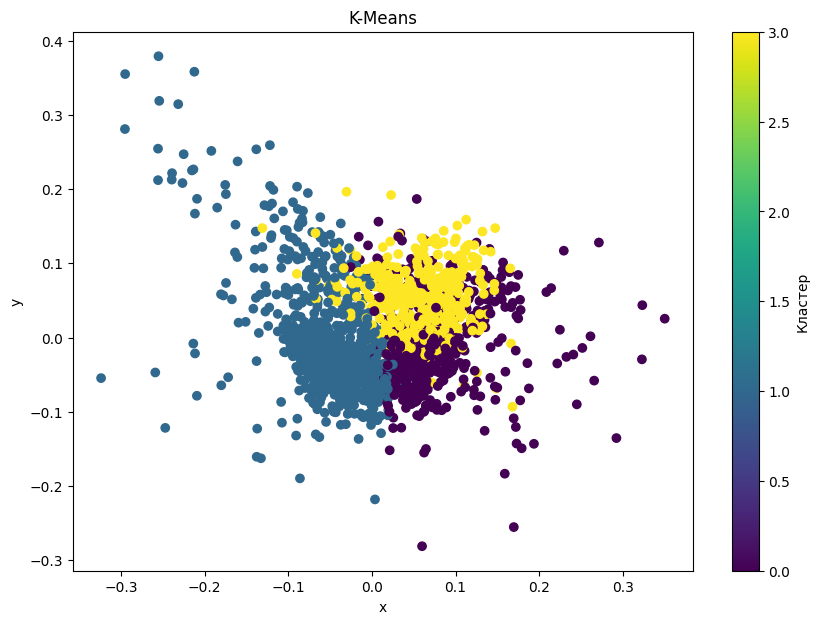

           date                                          embedding  Price  \
0    2010-01-19  [-0.00924612995, 0.007127481314285714, -0.0203...  75.18   
1    2010-01-21  [-0.009920224487777777, 0.013610265866666667, ...  74.13   
2    2010-01-25  [-0.022348197, 0.01205601, 0.001067863, 0.0181...  72.18   
3    2010-01-27  [0.038446907, 0.0515357, -0.034417834, 0.01247...  72.75   
4    2010-02-02  [-0.014653051297272728, -0.006172582718181818,...  73.94   
...         ...                                                ...    ...   
2158 2022-11-08  [-0.014146374315651506, 0.010602584802905306, ...  96.85   
2159 2022-11-09  [-0.009237897624380953, 0.009174246976571428, ...  93.05   
2160 2022-11-10  [-0.013892873195440003, 0.012858106044448005, ...  94.25   
2161 2022-11-11  [-0.014805941450202023, 0.013786822016969695, ...  96.37   
2162 2022-11-14  [-0.014843860892142857, 0.012554640770000005, ...  93.59   

      Cluster  
0           0  
1           1  
2           0  
3          

In [17]:
embeddings_matrix = np.vstack(merge_df['embedding'].values)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(embeddings_matrix)

# Указаниие у новости дня, к какому кластеру он относится
labels = kmeans.labels_
merge_df['Cluster'] = labels

# визуализация с уменьшением размерности эмбедингов с 1536 до 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_matrix)
plt.figure(figsize=(10, 5))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis')
plt.title('K-Means')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Кластер')
plt.show()

print(merge_df)

In [18]:
merge_df.head()

,date,embedding,Price,Cluster
0,2010-01-19,"[-0.00924612995, 0.007127481314285714, -0.0203...",75.18,0
1,2010-01-21,"[-0.009920224487777777, 0.013610265866666667, ...",74.13,1
2,2010-01-25,"[-0.022348197, 0.01205601, 0.001067863, 0.0181...",72.18,0
3,2010-01-27,"[0.038446907, 0.0515357, -0.034417834, 0.01247...",72.75,3
4,2010-02-02,"[-0.014653051297272728, -0.006172582718181818,...",73.94,0


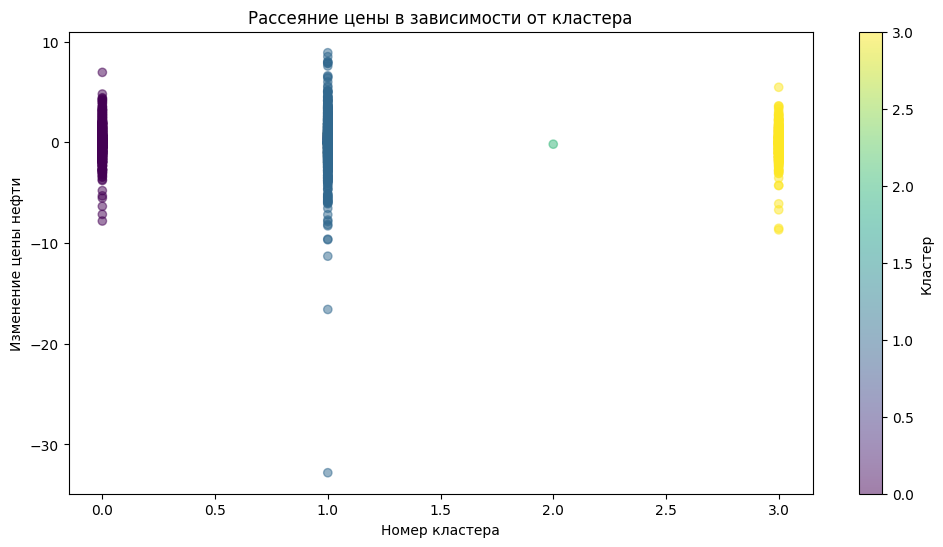

In [19]:
merge_df = merge_df.sort_values('date')

merge_df['Price_Change'] = merge_df['Price'].diff()

df = merge_df.dropna()

# Scatter Plot для изменения цены по кластерам
plt.figure(figsize=(10, 5))
plt.scatter(merge_df['Cluster'], merge_df['Price_Change'], c=merge_df['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Рассеяние цены в зависимости от кластера')
plt.xlabel('Номер кластера')
plt.ylabel('Изменение цены нефти')
plt.colorbar(label='Кластер')
plt.show()